In [1]:
import numpy as np
import qiskit.providers.aer.noise as noise
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import DensityMatrix, state_fidelity
from qiskit.visualization import plot_histogram
from qiskit import Aer

import matplotlib.pyplot as plt

As tree size increases, implementation gate length increases. We examine the optimal tree size at a fixed error rate 
p = ??

We consider one case as a proof of concept to avoid an excessive number of classical "if" operations.

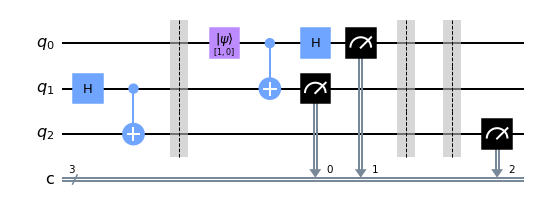

In [2]:
# Define circuit

def make_circuit_1(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(3, 'c')
    circ = QuantumCircuit(qr, cr)
    
    # Initialize qubits 1 and 2 in a Bell State
    circ.h(1)
    circ.cx(1, 2)
    circ.barrier()

    # Initialize qubit 0 in state
    circ.initialize(state, 0)
    
    # Bell measurement between messenger and root qubits
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 4, x2 in cbit 3
    circ.measure(0, 1)
    circ.measure(1, 0)
    circ.barrier()

    # Measure the encoded qubit into cbit 5
    circ.barrier()
    if meas_dir == 'z':
        circ.measure(2, 2)
    if meas_dir == 'x':
        circ.h(2)
        circ.measure(2, 2)
    
    return circ

circ = make_circuit_1([1, 0], 'z')
circ.draw('mpl')

In [3]:
def reconstruct_state(z_counts, x_counts):
    """
    Given histograms for x and z measurements, 
    reconstructs the state. 
    """
    def get_basis_ratio(counts):
        if '0' not in counts.keys():
            return (0, 1)
        elif '1' not in counts.keys():
            return (1, 0)
        else:
            total = counts['0'] + counts['1']
            return (counts['0'] / total, counts['1'] / total)
        
    z_ratio = get_basis_ratio(z_counts)
    z_exp = z_ratio[0] - z_ratio[1]
    
    x_ratio = get_basis_ratio(x_counts)
    x_exp = x_ratio[0] - x_ratio[1]
    
    ysq = 1 - z_exp * z_exp - x_exp * x_exp
    if ysq < 0:
        y_exp = 0
    else:
        y_exp = np.sqrt(ysq)
    
    # Return position on the Bloch sphere
    pos = np.array([x_exp, y_exp, z_exp])
    return pos / np.linalg.norm(pos)

def bloch_to_dm(vec):
    """
    Takes in a 3-tuple corresponding to a position 
    on the Bloch sphere and returns a density matrix.
    """
    identity = np.array([[1, 0], [0, 1]])
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    sigmaz = np.array([[1, 0], [0, -1]])
    return 1/2 * (identity + vec[0] * sigmax + vec[1] * sigmay + vec[2] * sigmaz)

def run_circuit_1(circ, p_err1, p_err2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(p_err1, 1)
    error_2 = noise.depolarizing_error(p_err2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    # Run the thing
    backend = Aer.get_backend('qasm_simulator')
    res = execute(circ, backend, basis_gates=basis_gates, noise_model=noise_model, shots=10000).result()
    counts = res.get_counts(circ)
    # Get results from the last measurement
    measurement = {}
    measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0' and key[1:] == '00'])
    measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1' and key[1:] == '00'])
    return measurement

def run_protocol_1(init_state, p_err1, p_err2):
    circ_z = make_circuit_1(init_state, 'z')
    circ_x = make_circuit_1(init_state, 'x')
    measurement_z = run_circuit_1(circ_z, p_err1, p_err2)
    measurement_x = run_circuit_1(circ_x, p_err1, p_err2)
    res_dm = bloch_to_dm(reconstruct_state(measurement_z, measurement_x))
    res_dm = DensityMatrix(res_dm)
    state = res_dm.to_statevector()
    return state_fidelity(init_state, state)

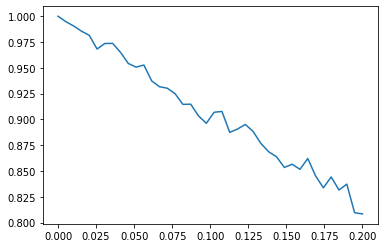

In [4]:
# Fidelity as a function of gate error for [1]-tree

init_state = [1, 0]
p_range = np.linspace(0, 0.2, 40)
fidelities_1 = [run_protocol_1(init_state, p, p) for p in p_range]

plt.plot(p_range, fidelities_1)

In [5]:
# Probability of Unobstructed Run

def run_prob_1(ploss):
    return 1 - ploss

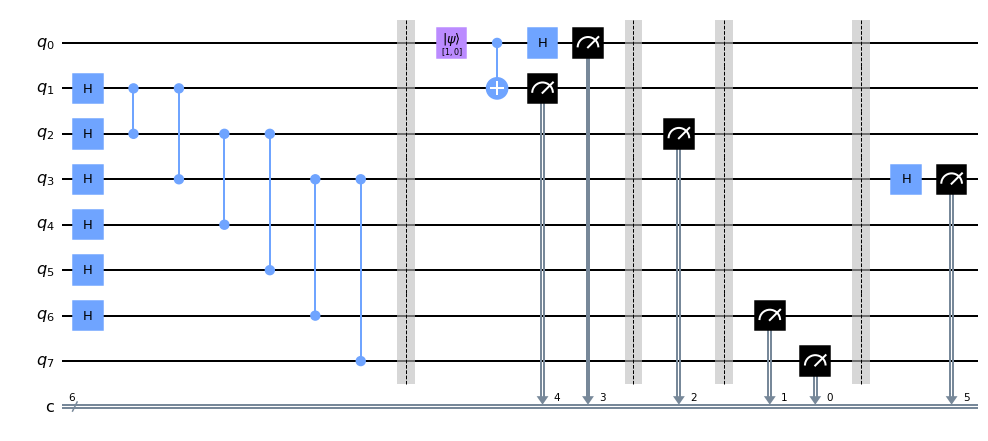

In [6]:
# Make [2,2] circuit in good case

def make_circuit_22_good(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(8, 'q')
    cr = ClassicalRegister(6, 'c')
    circ = QuantumCircuit(qr, cr)
    for i in range(1, 7):
        circ.h(i)
    circ.cz(1, 2)
    circ.cz(1, 3)
    circ.cz(2, 4)
    circ.cz(2, 5)
    circ.cz(3, 6)
    circ.cz(3, 7)
    circ.barrier()

    # Initialize messenger qubit
    circ.initialize(state, 0)
    
    # Bell measurement between messenger and root qubits
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 4, x2 in cbit 3
    circ.measure(0, 3)
    circ.measure(1, 4)
    circ.barrier()

    # Store x3 in cbit 2
    circ.measure(2, 2)
    circ.barrier()

    # Measure 2nd level qubits of branch 2 in z
    circ.measure(6, 1)
    circ.measure(7, 0)

    # Measure the encoded qubit into cbit 5
    circ.barrier()
    circ.h(3)
    if meas_dir == 'z':
        circ.measure(3, 5)
    if meas_dir == 'x':
        circ.h(3)
        circ.measure(3, 5)
    
    return circ

circ = make_circuit_22_good([1, 0], 'z')
circ.draw('mpl')

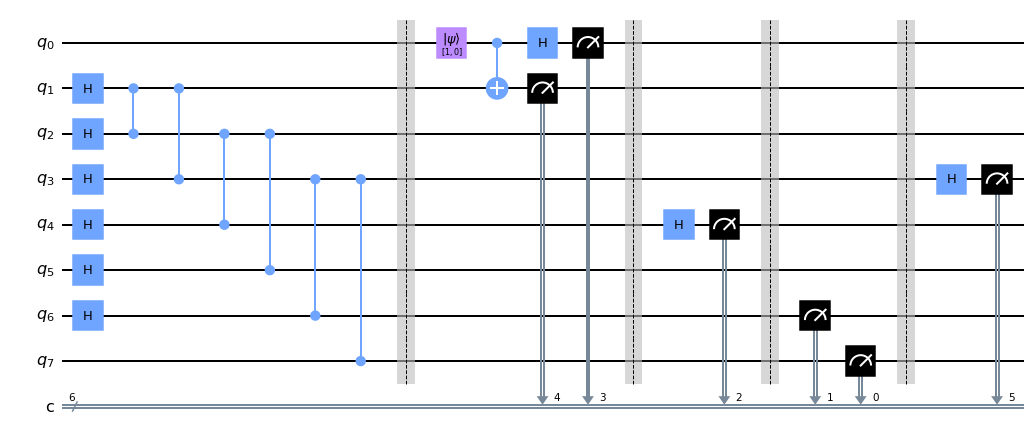

In [7]:
# Make [2,2] circuit in bad case

def make_circuit_22_bad(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(8, 'q')
    cr = ClassicalRegister(6, 'c')
    circ = QuantumCircuit(qr, cr)
    for i in range(1, 7):
        circ.h(i)
    circ.cz(1, 2)
    circ.cz(1, 3)
    circ.cz(2, 4)
    circ.cz(2, 5)
    circ.cz(3, 6)
    circ.cz(3, 7)
    circ.barrier()

    # Initialize messenger qubit
    circ.initialize(state, 0)
    
    # Bell measurement between messenger and root qubits
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 4, x2 in cbit 3
    circ.measure(0, 3)
    circ.measure(1, 4)
    circ.barrier()

    # Store x3 in cbit 2, measuring the leaf on the left tree
    circ.h(4)
    circ.measure(4, 2)
    circ.barrier()

    # Measure 2nd level qubits of branch 2 in z
    circ.measure(6, 1)
    circ.measure(7, 0)

    # Measure the encoded qubit into cbit 5
    circ.barrier()
    circ.h(3)
    if meas_dir == 'z':
        circ.measure(3, 5)
    if meas_dir == 'x':
        circ.h(3)
        circ.measure(3, 5)
    
    return circ

circ = make_circuit_22_bad([1, 0], 'z')
circ.draw('mpl')

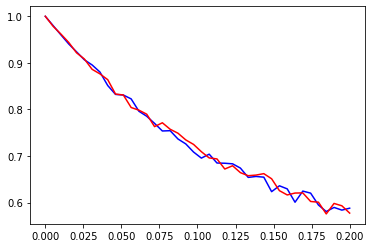

In [8]:
h_keys = ['00000', '00011', '01100', '01111', '10001', '10010', '11101', '11110']

def run_circuit_22(circ, p_err1, p_err2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(p_err1, 1)
    error_2 = noise.depolarizing_error(p_err2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    # Run the thing
    backend = Aer.get_backend('qasm_simulator')
    res = execute(circ, backend, basis_gates=basis_gates, noise_model=noise_model, shots=10000).result()
    counts = res.get_counts(circ)
    # Get results from the last measurement
    measurement = {}
    measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0' and key[1:] in h_keys])
    measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1' and key[1:] in h_keys])
    return measurement

def run_protocol_22(init_state, p_err1, p_err2, is_good):
    if is_good:
        circ_z = make_circuit_22_good(init_state, 'z')
        circ_x = make_circuit_22_good(init_state, 'x')
    else:
        circ_z = make_circuit_22_bad(init_state, 'z')
        circ_x = make_circuit_22_bad(init_state, 'x')
    measurement_z = run_circuit_22(circ_z, p_err1, p_err2)
    measurement_x = run_circuit_22(circ_x, p_err1, p_err2)
    res_dm = bloch_to_dm(reconstruct_state(measurement_z, measurement_x))
    res_dm = DensityMatrix(res_dm)
    state = res_dm.to_statevector()
    return state_fidelity(init_state, state)

# Fidelity as a function of gate error for [1]-tree

init_state = [1, 0]
p_range = np.linspace(0, 0.2, 40)
fidelities_22_good = [run_protocol_22(init_state, p, p, is_good=True) for p in p_range]
fidelities_22_bad = [run_protocol_22(init_state, p, p, is_good=False) for p in p_range]

plt.plot(p_range, fidelities_22_good, color='blue')
plt.plot(p_range, fidelities_22_bad, color='red')
plt.show()

In [9]:
from scipy import interpolate

fidelity_1 = interpolate.interp1d(p_range, fidelities_1)
fidelity_22_good = interpolate.interp1d(p_range, fidelities_22_good)
fidelity_22_bad = interpolate.interp1d(p_range, fidelities_22_bad)

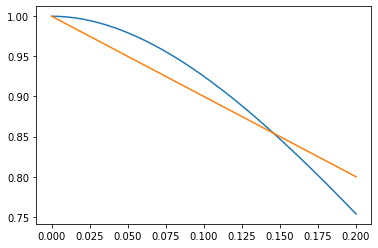

In [10]:
# Probability for Unobstructed Run in [2, 2] case

def run_prob_22_good(ploss):
    return (1-ploss) ** 6 + 4 * ploss * ((1-ploss) ** 5) + 2 * (ploss ** 2) * ((1-ploss) ** 4)
    
def run_prob_22_bad(ploss):
    return 2 * ploss * (1-ploss) ** 5 + 4 * (ploss ** 2) * (1 - ploss) ** 4 

run_prob_22_list = [run_prob_22_good(p) + run_prob_22_bad(p) for p in p_range]
run_prob_1_list = [run_prob_1(p) for p in p_range]
plt.plot(p_range, run_prob_22_list)
plt.plot(p_range, run_prob_1_list)

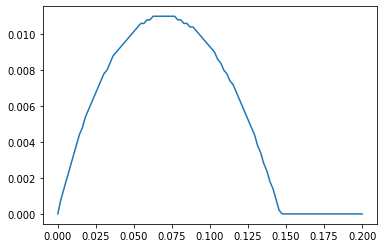

In [11]:
def p_threshold(ploss):
    """
    Given ploss, compute perr threshold where [2, 2] is better than [1].
    """
    test_p = np.linspace(0, 1, 5000)
    for perr in test_p:
        fidelity_1_val = run_prob_1(ploss) * fidelity_1(perr)
        fidelity_22_val = (run_prob_22_good(ploss) * fidelity_22_good(perr) 
                        + run_prob_22_bad(ploss) * fidelity_22_bad(perr))
        if fidelity_1_val > fidelity_22_val:
            return perr
        
    return 1

# p_threshold(0.02)

ploss_range = np.linspace(0, 0.2, 100)
thresholds = [p_threshold(ploss) for ploss in ploss_range]
plt.plot(ploss_range, thresholds)

### Comparison with [2,2,2]

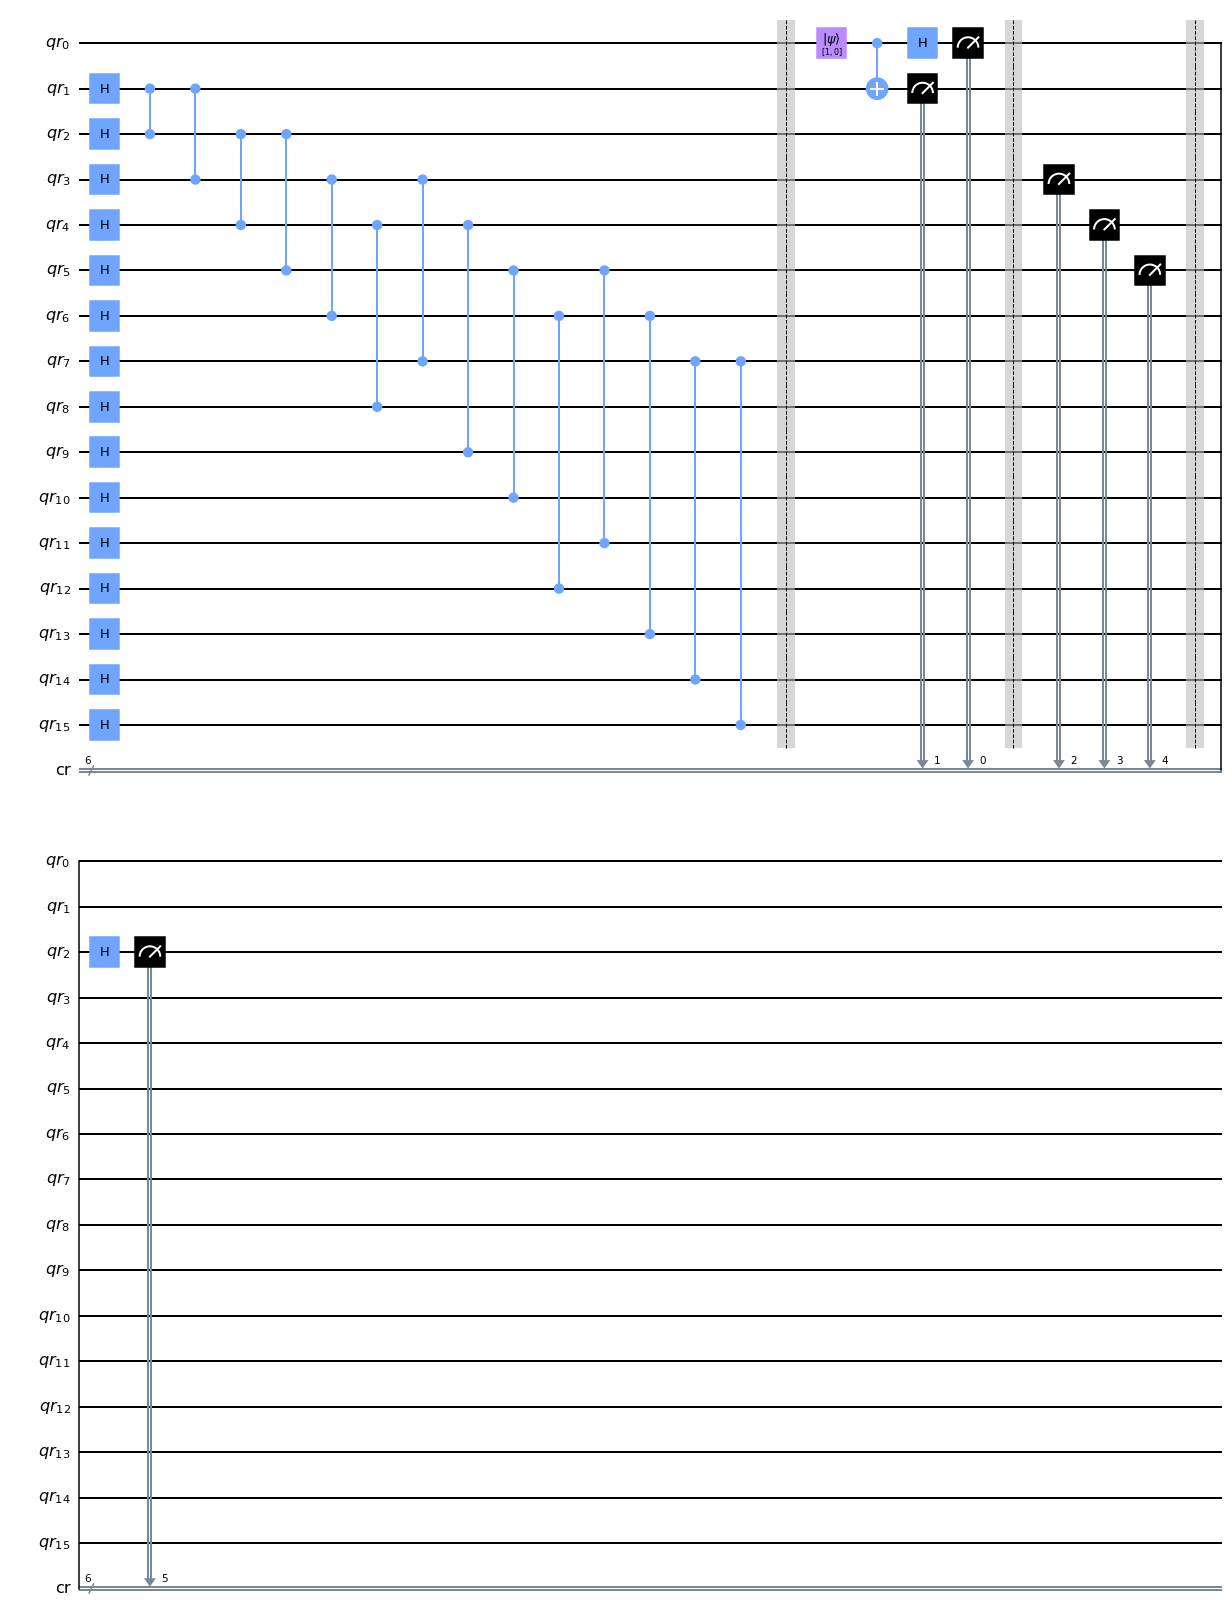

In [36]:
# Make [2,2,2] circuit in good case
#this is the case where the other (nontarget) subroot is not lost; in this case, there is no need to measure
#the rest of the branch

def make_circuit_222_good(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(6, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()
    
    # Initialize messenger qubit
    circ16.initialize(state, 0)
        
    #bell measurement between messenger and root qubits
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #store x3 in cbit 3
    circ16.measure(3, 2)
    
    #Z measurement on qubits in other (left) branch:
    circ16.measure(4, 3)
    circ16.measure(5, 4)

    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left, by measuring
    #option to measure in x or z:
    circ16.barrier()
    circ16.h(2)
    if meas_dir == 'z':
        circ16.measure(2, 5)
    if meas_dir == 'x':
        circ16.h(2)
        circ16.measure(2, 5)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16


circ = make_circuit_222_good([1, 0], 'z')
circ.draw('mpl')

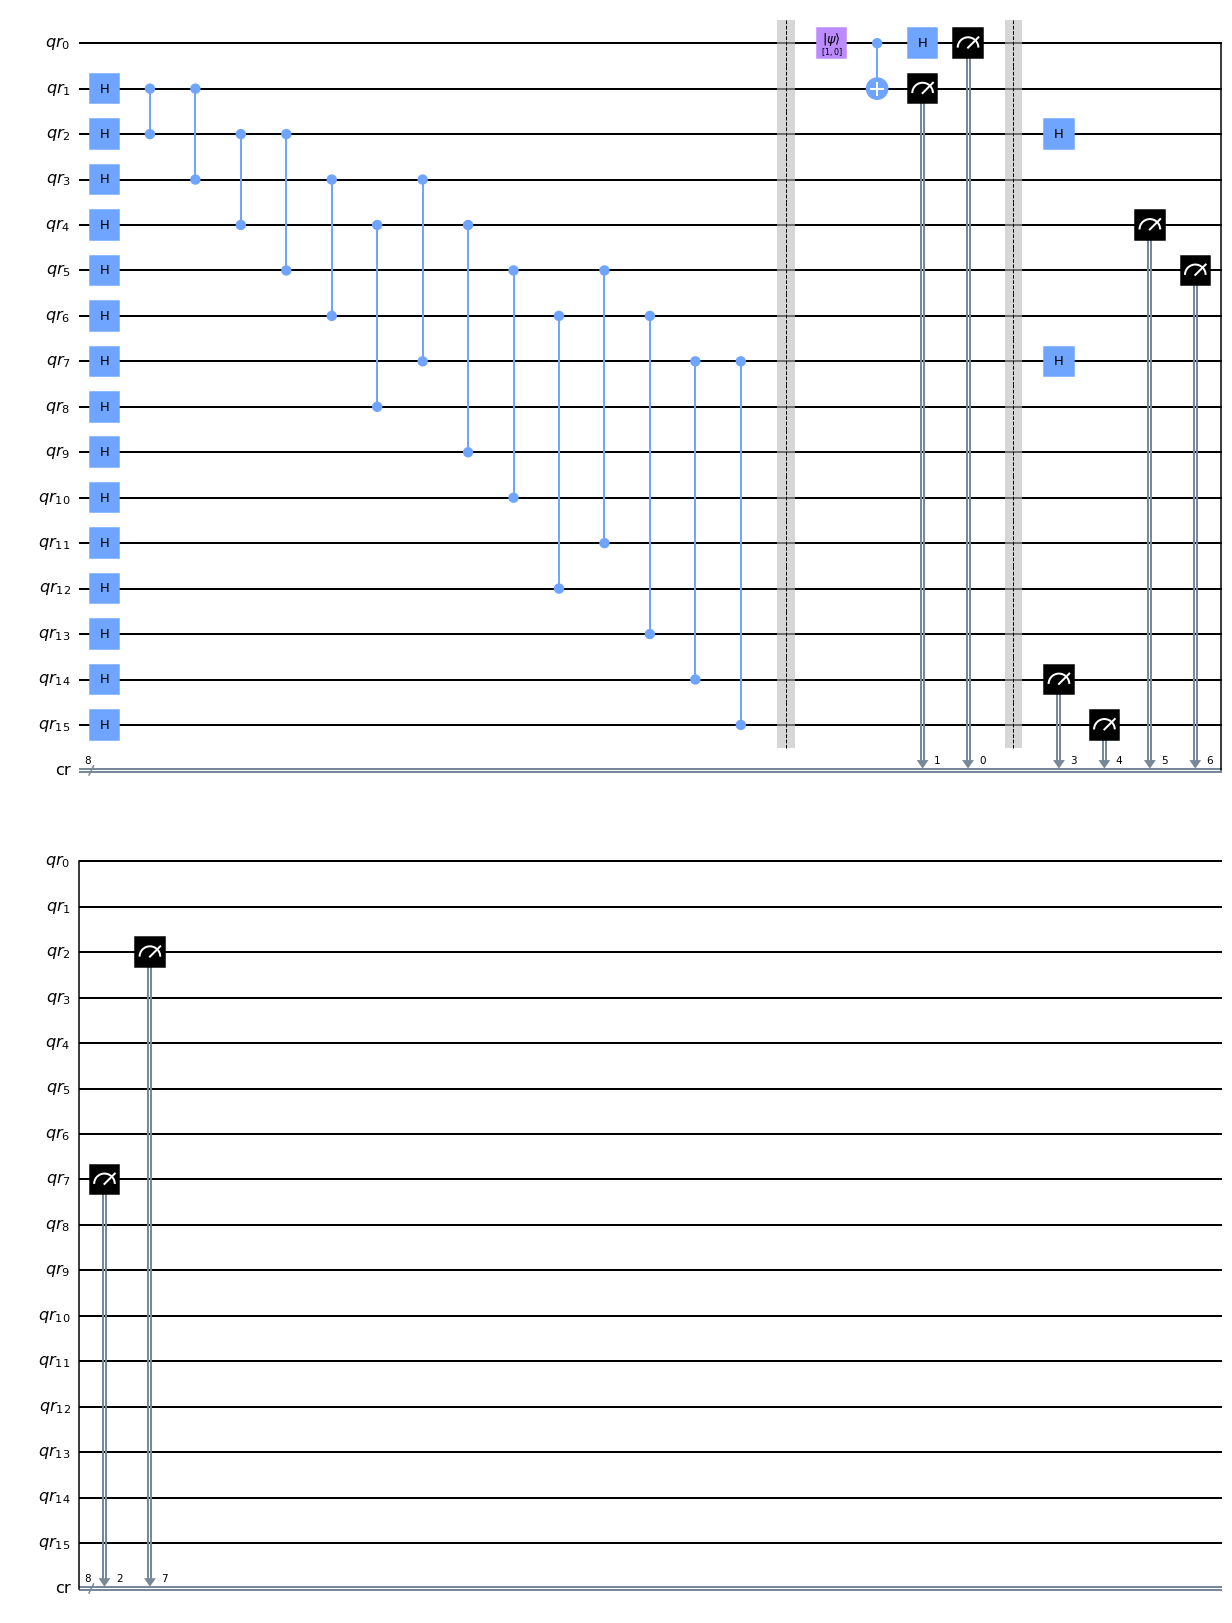

In [37]:
# Make [2,2,2] circuit in bad case

def make_circuit_222_bad(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(8, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()

    # Initialize messenger qubit
    circ16.initialize(state, 0)
    
    # Bell measurement between messenger and root qubits
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #LOST QUBIT 3 => need either subtree on the right to be full
    
    #X, Z, Z measurements on right subtree (qubits 7, 14, 15)
    circ16.h(7)
    circ16.measure(7, 2)
    #Z measurement on branch qubits
    circ16.measure(14, 3)
    circ16.measure(15, 4)
    
    #Z measurements on qubits in other (left) branch:
    circ16.measure(4, 5)
    circ16.measure(5, 6)
    
    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left
    circ16.h(2)
    circ16.measure(2, 7)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16

circ = make_circuit_222_bad([1, 0], 'z')
circ.draw('mpl')

In [ ]:
h_keys_good = ['00000']
h_keys_bad = ['0000000']

def run_circuit_222(circ, p_err1, p_err2, is_good):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(p_err1, 1)
    error_2 = noise.depolarizing_error(p_err2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    # Run the thing
    backend = Aer.get_backend('qasm_simulator')
    res = execute(circ, backend, basis_gates=basis_gates, noise_model=noise_model, shots=10000).result()
    counts = res.get_counts(circ)
    # Get results from the last measurement
    if is_good:
        measurement = {}
        measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0' and key[1:] in h_keys_good])
        measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1' and key[1:] in h_keys_good])
    else:
        measurement = {}
        measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0' and key[1:] in h_keys_bad])
        measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1' and key[1:] in h_keys_bad])
    return measurement        
    
def run_protocol_222(init_state, p_err1, p_err2, is_good):
    if is_good:
        circ_z = make_circuit_222_good(init_state, 'z')
        circ_x = make_circuit_222_good(init_state, 'x')
    else:
        circ_z = make_circuit_222_bad(init_state, 'z')
        circ_x = make_circuit_222_bad(init_state, 'x')
    measurement_z = run_circuit_222(circ_z, p_err1, p_err2, is_good)
    measurement_x = run_circuit_222(circ_x, p_err1, p_err2, is_good)
    res_dm = bloch_to_dm(reconstruct_state(measurement_z, measurement_x))
    res_dm = DensityMatrix(res_dm)
    state = res_dm.to_statevector()
    return state_fidelity(init_state, state)

# Fidelity as a function of gate error for [1]-tree

init_state = [1, 0]
p_range = np.linspace(0, 0.2, 40)
fidelities_222_good = [run_protocol_222(init_state, p, p, is_good=True) for p in p_range]
fidelities_222_bad = [run_protocol_222(init_state, p, p, is_good=False) for p in p_range]

plt.plot(p_range, fidelities_222_good, color='blue')
plt.plot(p_range, fidelities_222_bad, color='red')
plt.show()

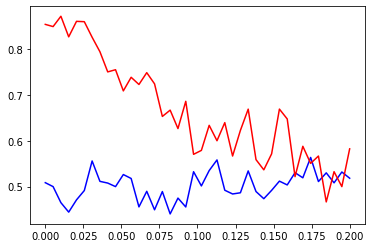

In [21]:
plt.plot(p_range, fidelities_222_good, color='blue')
plt.plot(p_range, fidelities_222_bad, color='red')
plt.show()

In [ ]:
### Processing just the bad ###

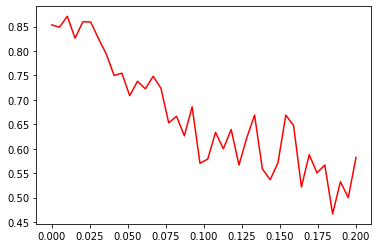

In [22]:
plt.plot(p_range, fidelities_222_bad, color='red')
plt.show()

In [26]:
#fidelity_222_good = interpolate.interp1d(p_range, fidelities_22_good)
fidelity_222_bad = interpolate.interp1d(p_range, fidelities_22_bad)

In [ ]:
# Probability for Unobstructed Run in [2, 2] case

#def run_prob_222_good(ploss):
#    return (1-ploss) ** 6 + 4 * ploss * ((1-ploss) ** 5) + 2 * (ploss ** 2) * ((1-ploss) ** 4)
    
def run_prob_222_bad(ploss):
    return 2 * ploss * (1-ploss) ** 5 + 4 * (ploss ** 2) * (1 - ploss) ** 4 

#run_prob_222_list = [run_prob_222_good(p) + run_prob_222_bad(p) for p in p_range]
run_prob_1_list = [run_prob_1(p) for p in p_range]
plt.plot(p_range, run_prob_22_list)
plt.plot(p_range, run_prob_1_list)

In [ ]:
### bad case: leaves measured in Z, roots measured in X (see figure 2d) ###

In [ ]:
def make_circuit_22_good(state, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(8, 'q')
    cr = ClassicalRegister(6, 'c')
    circ = QuantumCircuit(qr, cr)
    for i in range(1, 7):
        circ.h(i)
    circ.cz(1, 2)
    circ.cz(1, 3)
    circ.cz(2, 4)
    circ.cz(2, 5)
    circ.cz(3, 6)
    circ.cz(3, 7)
    circ.barrier()

    # Initialize messenger qubit
    circ.initialize(state, 0)
    
    # Bell measurement between messenger and root qubits
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 4, x2 in cbit 3
    circ.measure(0, 3)
    circ.measure(1, 4)
    circ.barrier()

    # Store x3 in cbit 2
    circ.measure(2, 2)
    circ.barrier()

    # Measure 2nd level qubits of branch 2 in z
    circ.measure(6, 1)
    circ.measure(7, 0)

    # Measure the encoded qubit into cbit 5
    circ.barrier()
    circ.h(3)
    if meas_dir == 'z':
        circ.measure(3, 5)
    if meas_dir == 'x':
        circ.h(3)
        circ.measure(3, 5)
    
    return circ

circ = make_circuit_22_good([1, 0], 'z')
circ.draw('mpl')

In [ ]:
#####################################
### [2, 2, 2] with loss above #######
### [2, 2, 2] specific case below ###
#####################################

In [45]:
def circuit_with_messenger_initialization(theta, direction):
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(6, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()
    # Initialize messenger qubit
    if direction == 'z':
        # Start in x eigenstate, rotate about z-axis
        circ16.h(0)
        circ16.p(theta, 0)
    
    if direction == 'x':
        circ16.h(0)
        circ16.p(-theta, 0)
        circ16.h(0)
        
    if direction == 'y':
        circ16.sdg(0); circ16.h(0)
        circ16.p(theta, 0)
        circ16.h(0); circ16.s(0)
        
    #bellmeasurement
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #store x3 in cbit 3
    circ16.measure(3, 2)
    
    #Z measurement on qubits in other (left) branch:
    circ16.measure(4, 3)
    circ16.measure(5, 4)
    
    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left
    circ16.h(2)
    circ16.measure(2, 5)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16


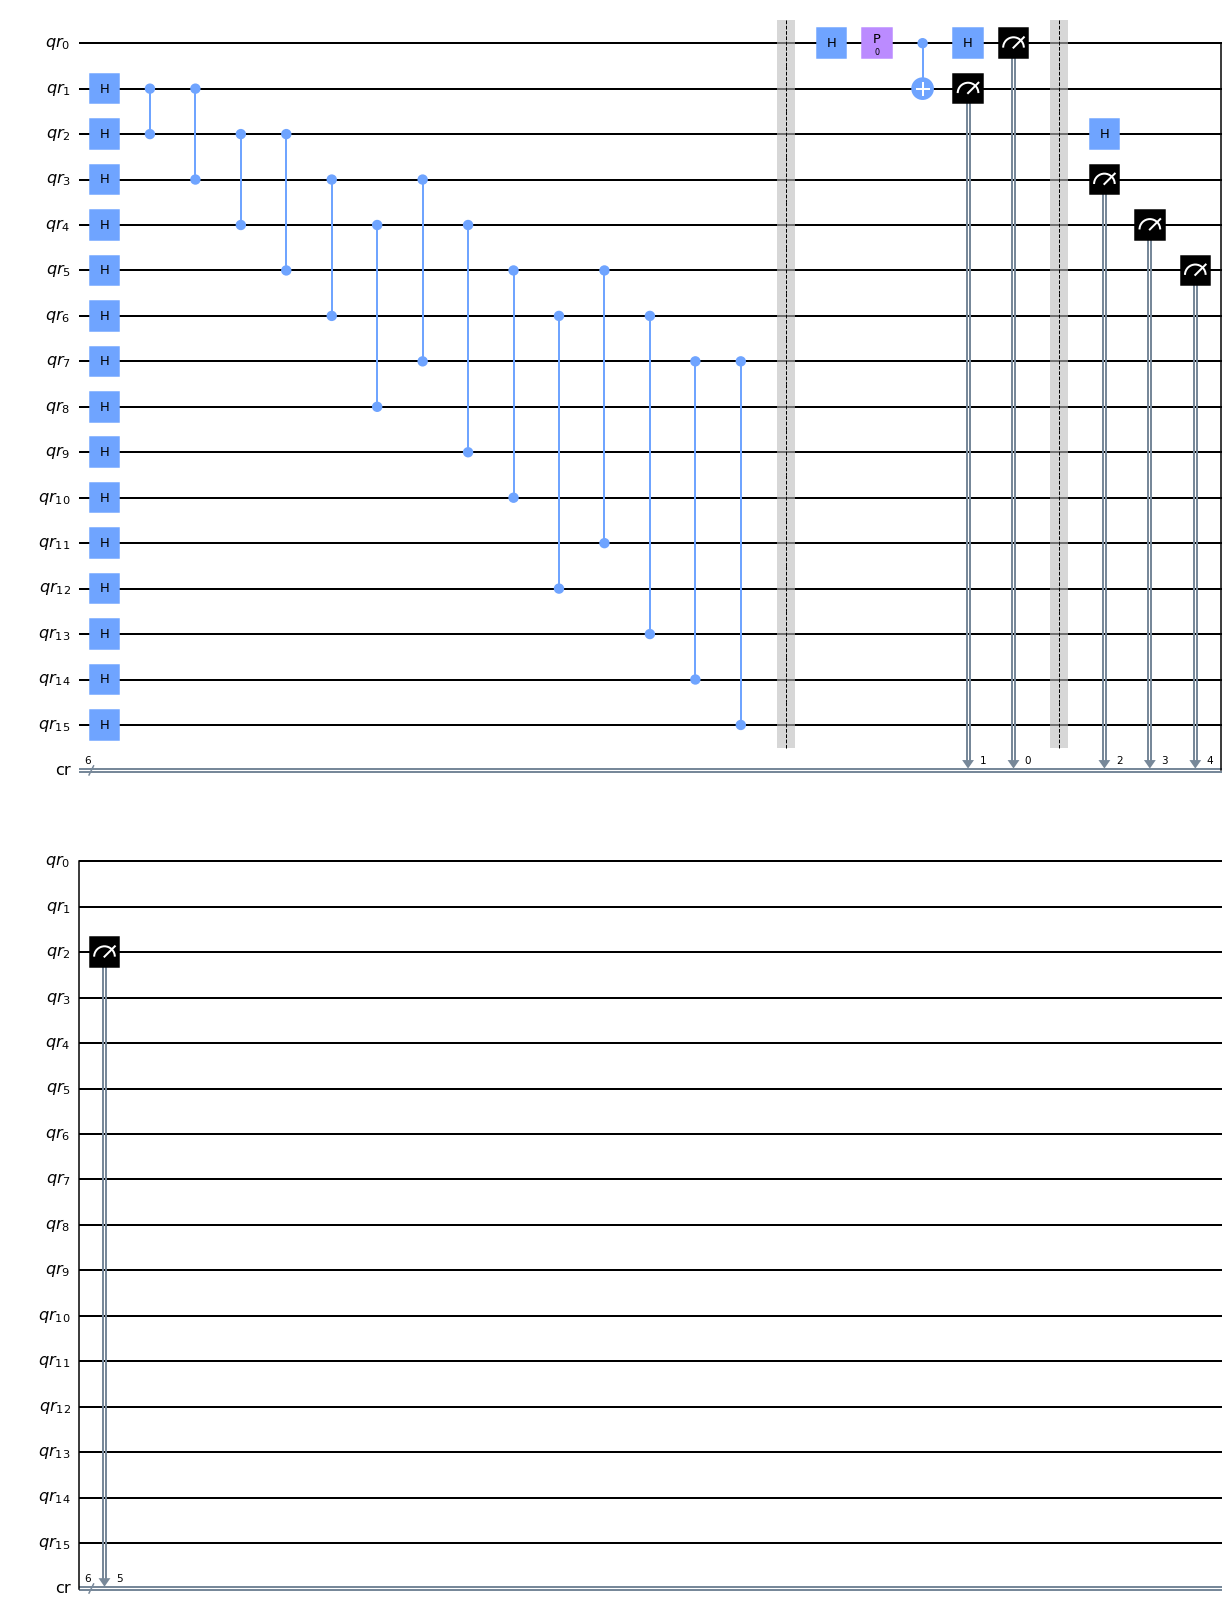

In [46]:
circuit_with_messenger_initialization(0, 'z').draw('mpl')

In [47]:
theta_list = np.linspace(0, np.pi, 20)
jobs_z = {}
backend = Aer.get_backend('qasm_simulator')

circ = circuit_with_messenger_initialization(0, 'z')
job = backend.run(transpile(circ, backend), shots = 10000)

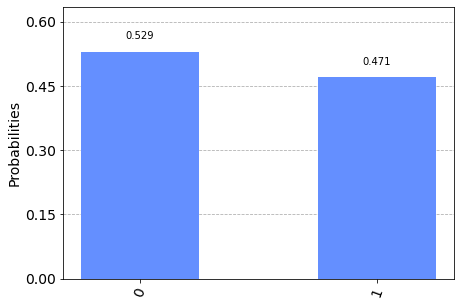

In [48]:
results = job.result()
counts = results.get_counts()
counts_filtered = {key[0] : val for key, val in counts.items() if key[1:]=='00000'}
plot_histogram(counts_filtered)

In [49]:
##Case 2: Lost the root photon of the right branch

In [50]:
def circuit_with_messenger_initialization_no_right_root(theta, direction):
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(8, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()
    # Initialize messenger qubit
    if direction == 'z':
        # Start in x eigenstate, rotate about z-axis
        circ16.h(0)
        circ16.p(theta, 0)
    
    if direction == 'x':
        circ16.h(0)
        circ16.p(-theta, 0)
        circ16.h(0)
        
    if direction == 'y':
        circ16.sdg(0); circ16.h(0)
        circ16.p(theta, 0)
        circ16.h(0); circ16.s(0)
        
    #bellmeasurement
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #LOST QUBIT 3 => need either subtree on the right to be full
    
    #X, Z, Z measurements on right subtree (qubits 7, 14, 15)
    circ16.h(7)
    circ16.measure(7, 2)
    circ16.measure(14, 3)
    circ16.measure(15, 4)
    
    #Z measurements on qubits in other (left) branch:
    circ16.measure(4, 5)
    circ16.measure(5, 6)
    
    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left
    circ16.h(2)
    circ16.measure(2, 7)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16


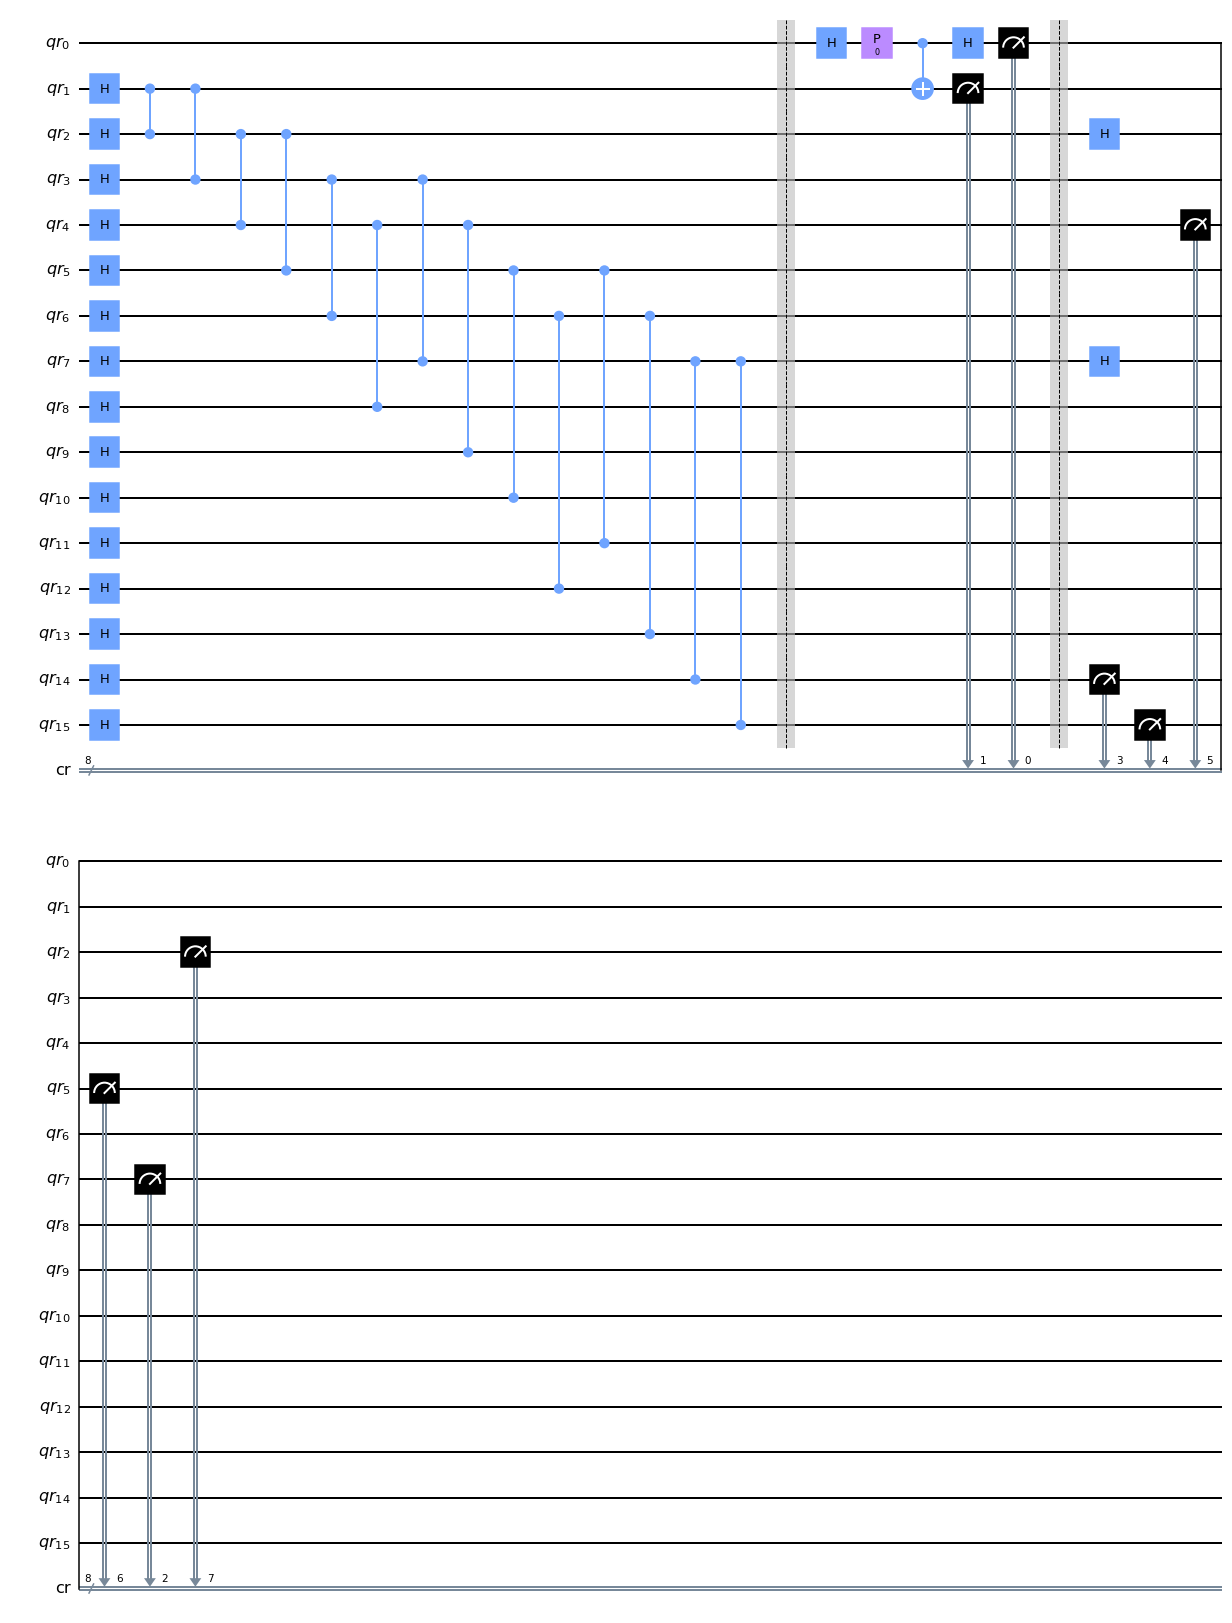

In [51]:
circuit_with_messenger_initialization_no_right_root(0, 'z').draw('mpl')

In [52]:
theta_list = np.linspace(0, np.pi, 20)
jobs_z = {}
backend = Aer.get_backend('qasm_simulator')

circ = circuit_with_messenger_initialization_no_right_root(0, 'z')
job = backend.run(transpile(circ, backend), shots = 10000)

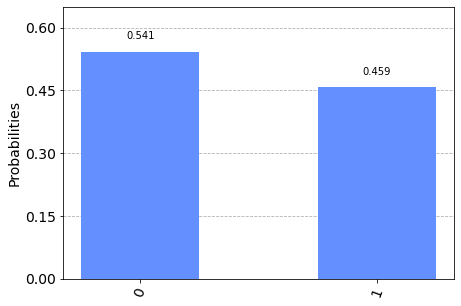

In [53]:
results = job.result()
counts = results.get_counts()
counts_filtered = {key[0] : val for key, val in counts.items() if key[1:]=='0000000'}
plot_histogram(counts_filtered)